# افزودن پکیج‌های مورد نیاز

In [3]:
from matplotlib import pyplot as plt
import numpy as np
import json
import requests
import pandas as pd
import time
from keras.layers import Dropout, Dense, Activation, LSTM
from keras.models import Sequential

from datetime import datetime  
from datetime import timedelta  

/Users/Future/anaconda/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


# توابع مورد نیاز

In [4]:
def line_plot(line1, line2, label1=None, label2=None, title=''):
    fig, ax = plt.subplots(1, figsize=(25, 15))
    ax.plot(line1, label=label1, linewidth=2)
    ax.plot(line2, label=label2, linewidth=2)
    
    for i, j in zip(line1, line2):
        ax.plot([], [],)
    
    ax.set_ylabel('price [USD]', fontsize=14)
    ax.set_title(title, fontsize=18)
    ax.legend(loc='best', fontsize=18)
    plt.show()
    
    
def train_test_split(df, test_size=0.1):
    split_row = len(df) - int(test_size * len(df))
    train_data = df.iloc[:split_row]
    test_data = df.iloc[split_row:]
    return train_data, test_data


def normalise_zero_base(df):
    """ Normalise dataframe column-wise to reflect changes with
        respect to first entry.
    """
    return df / df.iloc[0] - 1


def extract_window_data(df, window=7, zero_base=True):
    """ Convert dataframe to overlapping sequences/windows of
        length `window`.
    """
    window_data = []
    for idx in range(len(df) - window):
        tmp = df[idx: (idx + window)].copy()
        if zero_base:
            tmp = normalise_zero_base(tmp)
        window_data.append(tmp.values)
    return np.array(window_data)


def prepare_data(df, window=7, zero_base=True, test_size=0.1):
    """ Prepare data for LSTM. """
    # train test split
    train_data, test_data = train_test_split(df, test_size)
    
    # extract window data
    X_train = extract_window_data(train_data, window, zero_base)
    X_test = extract_window_data(test_data, window, zero_base)
    
    # extract targets
    y_train = train_data.close[window:].values
    y_test = test_data.close[window:].values
    if zero_base:
        y_train = y_train / train_data.close[:-window].values - 1
        y_test = y_test / test_data.close[:-window].values - 1
    return train_data, test_data, X_train, X_test, y_train, y_test


def build_lstm_model(input_data, output_size, neurons=20,
                     activ_func='linear', dropout=0.25,
                     loss='mae', optimizer='adam'):
    model = Sequential()
    model.add(LSTM(neurons, input_shape=(
              input_data.shape[1], input_data.shape[2])))
    model.add(Dropout(dropout))
    model.add(Dense(units=output_size))
    model.add(Activation(activ_func))
    model.compile(loss=loss, optimizer=optimizer)
    return model

----------

# انتخاب سکه مورد نظر

In [5]:
coin = 'BTC'

# دریافت داده‌ها

In [6]:
endpoint = 'https://min-api.cryptocompare.com/data/histoday'
res = requests.get(endpoint + '?fsym='+coin+'&tsym=USD&limit=2000')
hist = pd.DataFrame(json.loads(res.content)['Data'])
hist = hist.set_index('time')
hist.index = pd.to_datetime(hist.index, unit='s')
hist.tail()

,close,high,low,open,volumefrom,volumeto
time,,,,,,
2018-07-17,7326.70,7476.24,6677.56,6740.54,112707.21,7.994015e+08
2018-07-18,7383.39,7590.65,7253.71,7326.76,105818.71,7.884608e+08
2018-07-19,7477.50,7563.70,7289.90,7383.39,70179.39,5.225444e+08
2018-07-20,7333.93,7676.55,7279.34,7477.10,80874.93,6.030344e+08
2018-07-21,7327.74,7335.53,7220.37,7333.93,14366.82,1.051229e+08


------

---------

# تعیین پارامترهای آموزش

In [7]:
target_col = 'close'
test_size = 0.1
window = 3


# جداسازی داده‌های آموزش و تست

### نمایش مرز جداسازی بین داده‌ها در طی زمان برای آموزش و تست

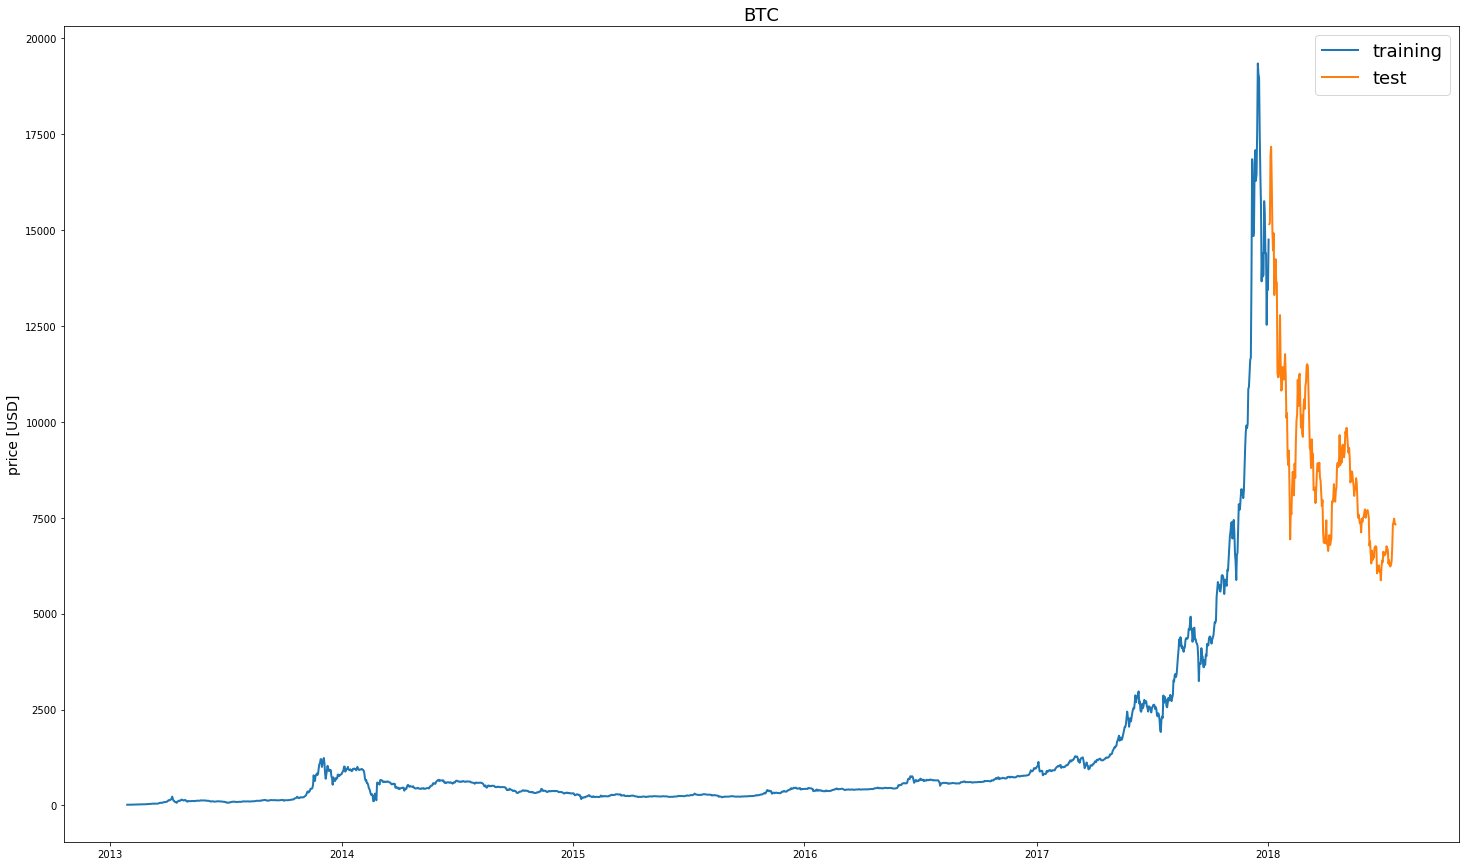

In [8]:
train, test = train_test_split(hist, test_size)
line_plot(train[target_col], test[target_col], 'training', 'test', coin)

In [9]:
print(30*'-'+' TRAIN TAIL '+30*'-'+'\n')
print(train.tail())
print(72*'=')

print('\n\n'+30*'-'+' TEST HEAD '+31*'-'+'\n')
print(test.head())
print(72*'=')

------------------------------ TRAIN TAIL ------------------------------

               close      high       low      open  volumefrom      volumeto
time                                                                        
2017-12-29  14392.57  15109.81  13951.08  14398.45   118874.63  1.733584e+09
2017-12-30  12531.52  14461.46  11962.09  14392.14   182065.44  2.387311e+09
2017-12-31  13850.40  14241.82  12359.43  12532.38   111270.55  1.492142e+09
2018-01-01  13444.88  13921.53  12877.67  13850.49    78425.21  1.057522e+09
2018-01-02  14754.13  15306.13  12934.16  13444.88   137732.17  1.956783e+09


------------------------------ TEST HEAD -------------------------------

               close      high       low      open  volumefrom      volumeto
time                                                                        
2018-01-03  15156.62  15435.01  14579.71  14754.09   106543.39  1.604207e+09
2018-01-04  15180.08  15408.66  14244.67  15156.49   110968.82  1.656715e+09
201

### مهیاسازی داده‌ها برای آموزش و تست

In [14]:
train, test, X_train, X_test, y_train, y_test = prepare_data(hist, test_size=test_size, window=window)
X_train.shape

(1798, 3, 6)

------

# پارمترهای آموزش

In [16]:
epochs=5
batch_size=4

extra_param ={
    'neurons':20,
    'activ_func':'linear',
    'dropout':0.25,
    'loss':'mae',
    'optimizer':'adam'
}

# آموزش شبکه

In [19]:
model = build_lstm_model(X_train, output_size=1, **extra_param)
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), batch_size=batch_size, epochs=epochs, verbose=2)

Train on 1798 samples, validate on 197 samples
Epoch 1/5
 - 2s - loss: 0.0602 - val_loss: 0.0459
Epoch 2/5
 - 2s - loss: 0.0456 - val_loss: 0.0400
Epoch 3/5
 - 2s - loss: 0.0415 - val_loss: 0.0379
Epoch 4/5
 - 2s - loss: 0.0388 - val_loss: 0.0382
Epoch 5/5
 - 2s - loss: 0.0376 - val_loss: 0.0365


--------

# پارامترهای تست

In [20]:
f_test[target_col][-window:]

NameError: name 'f_test' is not defined

In [152]:
np.random.randn(1)/10

array([-0.00513512])

[6714.5299999999997]
(200, 6)
(201, 6)
(202, 6)
(203, 6)
(204, 6)
(205, 6)
(206, 6)
(207, 6)
(208, 6)
(209, 6)
(210, 6)
(211, 6)
(212, 6)
[6714.5299999999997, 6896.5235077007856, 6892.6931830987551, 6845.6719185045913, 6266.3688282197973, 5352.426947644115, 4312.3464100468436, 3136.52628532672, 2705.1030418579212, 2284.9405827498695, 1865.6518933449138, 1621.5914434736794, 1421.8169484290115, 1502.2452944537804]


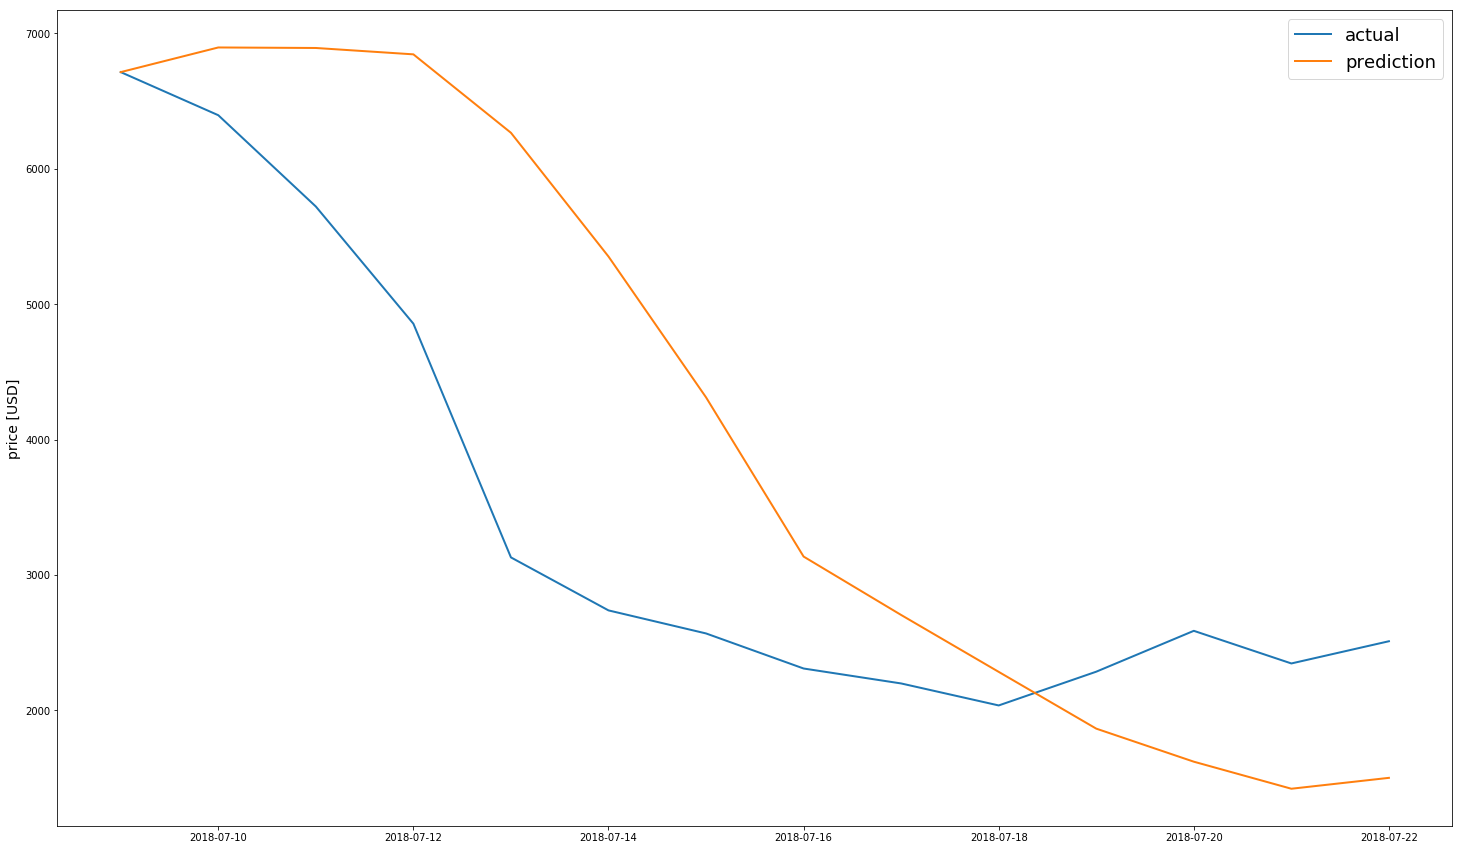

In [153]:
f_test = test.copy()
f_X_test = X_test.copy()

n_after = 13

res = [test['close'][-1]]
print res
for i in range(n_after):
    x_test = np.array([f_X_test[-1,:,:],])
#     print x_test
    
    pred = model.predict(x_test).squeeze()
    res.append(res[-1]*(pred + 1))
    
    rnds = np.random.randn(6)/6
    f_close = f_test['close'][-1]*(pred+rnds[0]+1);
    f_high =  f_test['high'][-1]*(pred+rnds[1]+1);
    f_low = f_test['low'][-1]*(pred+rnds[2]+1);
    f_open = f_test['open'][-1]*(pred+rnds[3]+1);
    f_volumefrom = f_test['volumefrom'][-1]*(pred+rnds[4]+1);
    f_volumeto = f_test['volumeto'][-1]*(pred+rnds[5]+1);
    
    print f_test.shape
    
    f_test.loc[str((datetime.utcnow() + timedelta(days=1+i)).date())] = [f_close, f_high, f_low, f_open, f_volumefrom, f_volumeto]
    f_X_test = extract_window_data(f_test, window, True)
    
    
print res

# convert change predictions back to actual price
targets = f_test[target_col][-n_after-1:]
preds = pd.Series(index=targets.index, data=res)
line_plot(targets[-n:], preds[-n:], 'actual', 'prediction')

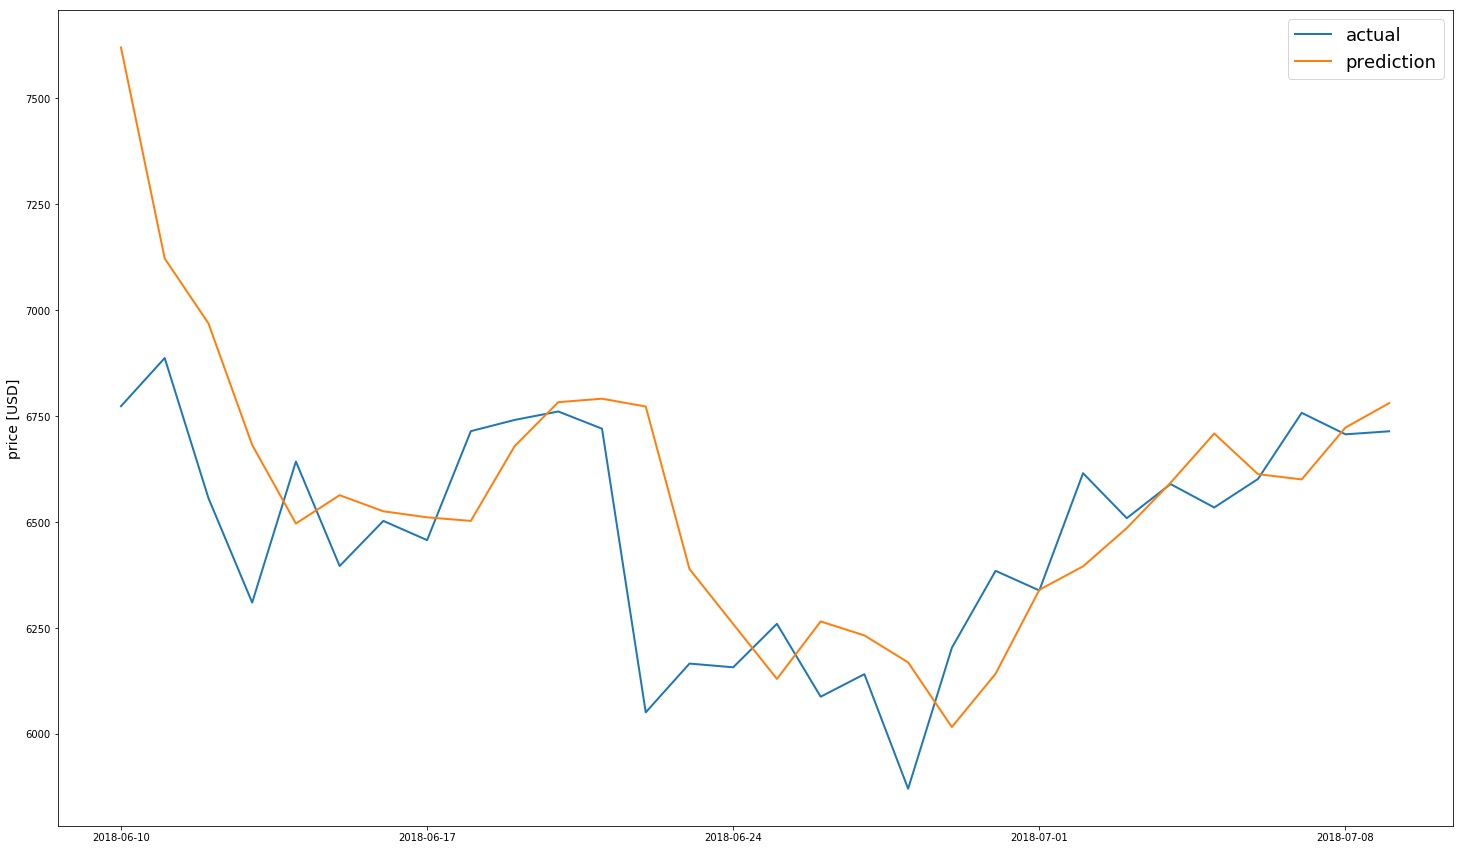

In [158]:
targets = test[target_col][window:]
preds = model.predict(X_test).squeeze()
# convert change predictions back to actual price
preds = test.close.values[:-window] * (preds + 1)
preds = pd.Series(index=targets.index, data=preds)
n = 30
line_plot(targets[-n:], preds[-n:], 'actual', 'prediction')

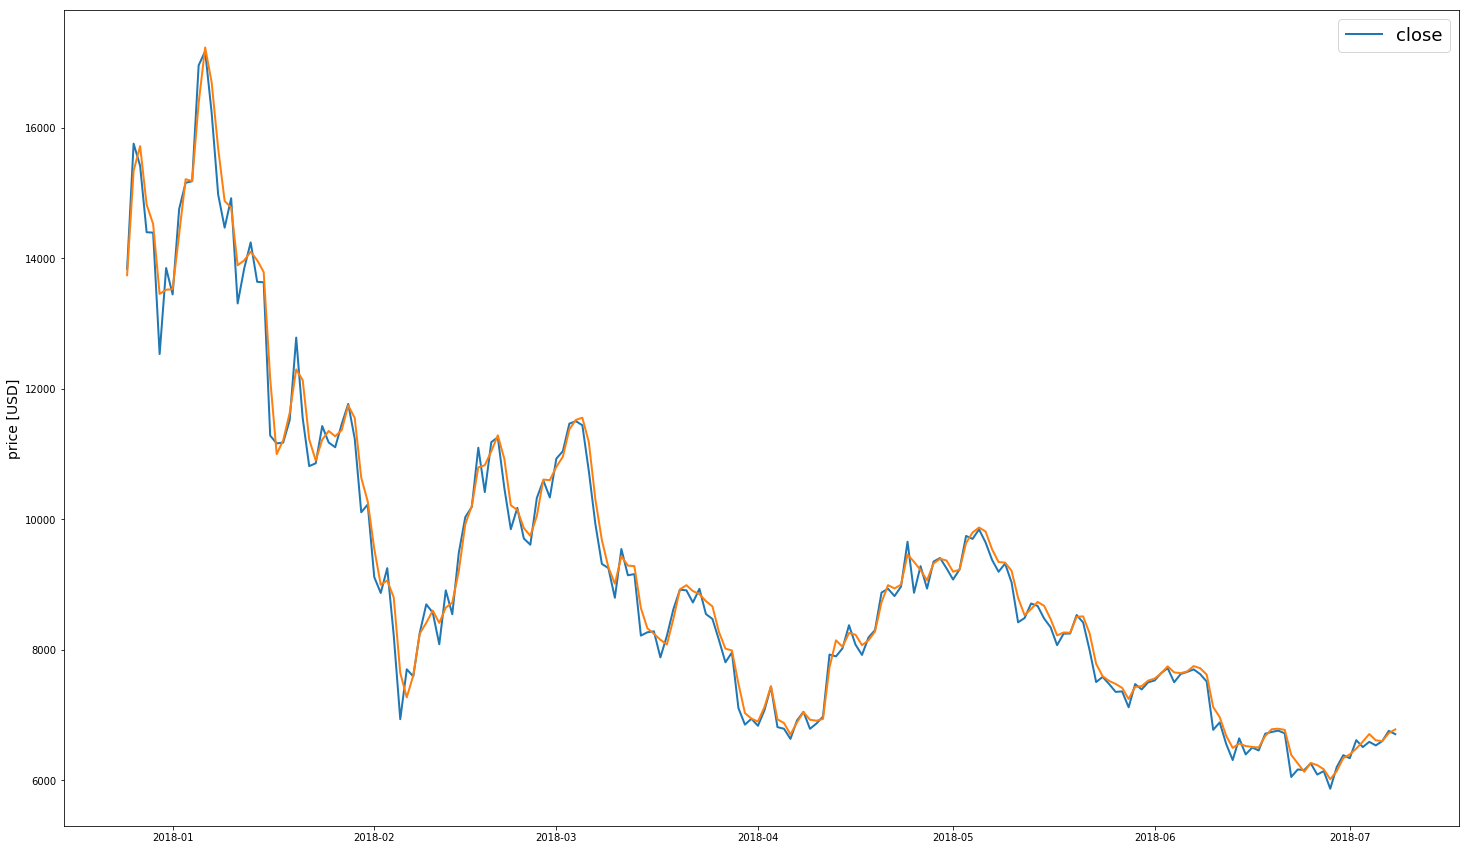

In [155]:
line_plot(targets[-n:][:-1], preds[-n:].shift(-1))

In [156]:
actual_returns = targets.pct_change()[1:]
predicted_returns = preds.pct_change()[1:]

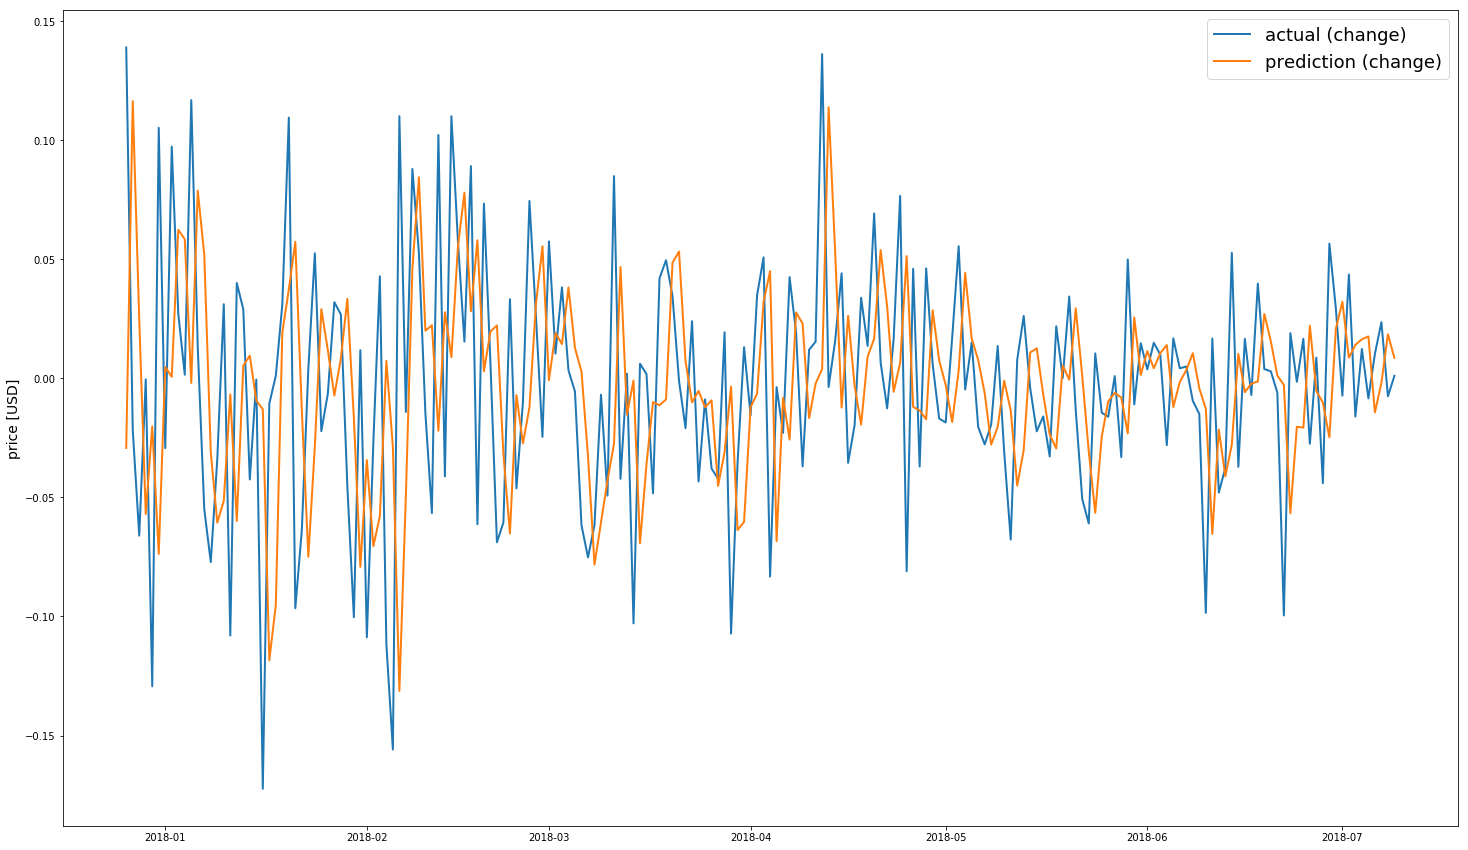

In [157]:
line_plot(actual_returns, predicted_returns, 'actual (change)', 'prediction (change)')

In [ ]:
targets = test[target_col][window:]
preds = model.predict(X_test).squeeze()
# convert change predictions back to actual price
preds = test.close.values[:-window] * (preds + 1)
preds = pd.Series(index=targets.index, data=preds)
n = 30*7
line_plot(targets[-n:], preds[-n:], 'actual', 'prediction')